In [2]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import sem
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import ttest_rel,ttest_ind,wilcoxon
import json
import statsmodels.api as sm
import pylab as py

In [3]:
plt.rcParams.update(plt.rcParamsDefault)

In [4]:
home_dir = '/Users/dbao/google_drive_db'+'/road_construction/data/2022_online/'
home_dir = '../../../2022_online/'
map_dir = 'active_map/'
data_dir  = 'data/preprocessed'
# out_dir = home_dir + 'figures/cogsci_2022/'
out_dir = './figures_dk/'
R_out_dir = home_dir + 'R_analysis_data/'

In [5]:
data_puzzle_level = pd.read_csv(R_out_dir +  'data.csv')
puzzleID_order_data = data_puzzle_level.sort_values(["subjects","puzzleID"])
data_choice_level = pd.read_csv(R_out_dir +  'choice_level/choicelevel_data.csv')

single_condition_data = puzzleID_order_data[puzzleID_order_data['condition']==1].copy()
single_condition_data = single_condition_data.reset_index()
sc_data_choice_level = data_choice_level[data_choice_level['condition']==1].reset_index()

# Figure 1

## map

calculate direction of greedy choice and optimal choice to visualize the difference

In [6]:
with open(home_dir + map_dir + 'tree/map_tree_trueopt', 'r') as file:
    map_tree = json.load(file)

with open(home_dir + map_dir + '/basicMap.json', 'r') as file:
    map = json.load(file)

In [7]:
def find_sublist_index(target, list_of_sublists):
    try:
        return list_of_sublists.index(target)
    except ValueError:
        return -1  # returns -1 if the sublist is not found

In [8]:
# compariosn between performance
undo_level = data_choice_level[data_choice_level['condition']==1].copy().reset_index()
basic_level = data_choice_level[data_choice_level['condition']==0].copy().reset_index()

len_gdy_opt = []
len_diff = []

for sub in range(1):

    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"])
    dat_sbj_undo  = undo_level[undo_level['subjects']==sub].sort_values(["puzzleID","index"])
    dat_sbj_basic  = basic_level[basic_level['subjects']==sub].sort_values(["puzzleID","index"])

    len_gdy_opt_puzzle = []

    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        TS = map[pzi]

        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()
        dat_sbj_undo_pzi = dat_sbj_undo[dat_sbj_undo['puzzleID'] == pzi].reset_index()
        dat_sbj_basic_pzi = dat_sbj_basic[dat_sbj_basic['puzzleID'] == pzi].reset_index()

        # get distance from TS['xy'][0] to TS['xy'][1:]
        start = np.array(TS['xy'][0])
        distance = [np.sum(np.sqrt((start - np.array(node))**2)) for node in TS['xy'][1:]]

        TS = map[pzi]

        R = 300.0

        rem_xy = TS['xy'].copy()
        # pop the current one
        curr_xy = rem_xy.pop(0)
        cts_in_order = []
        cts_in_order.append(curr_xy)
        cts_idx_in_order = [find_sublist_index(curr_xy, TS['xy'])]

        while R > 0:
            # get list of distances between curr_xy and every element in rem_xy
            # distance = [np.sum(np.sqrt((np.array(curr_xy) - np.array(node))**2)) for node in rem_xy]
            distance = [TS['distance'][find_sublist_index(curr_xy, TS['xy'])][find_sublist_index(node, TS['xy'])] for node in rem_xy]

            # find the argmin for distance
            idx = np.argmin(distance)

            curr_xy = rem_xy.pop(idx)

            R -= distance[idx]

            if R <= 0:
                break

            cts_in_order.append(curr_xy)
            cts_idx_in_order.append(find_sublist_index(curr_xy, TS['xy']))

        len_gdy = len(cts_in_order)
        len_opt = np.array(map_tree[pzi]['mas']).max()
        len_gdy_opt_puzzle.append([len_gdy, len_opt])
        opt_paths = map_tree[pzi]['paths'][np.argmax([len(path) for path in map_tree[pzi]['paths']])]

        len_diff.append(np.sum(np.array(cts_idx_in_order)[:4]==np.array(opt_paths)[:4]))

    # append mean of greedy_action_puzzle, error_action_puzzle
    len_gdy_opt.append(np.mean(len_gdy_opt_puzzle, axis=0))



len_gdy_opt = np.array(len_gdy_opt)

/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_97199/1059296280.py:61: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  len_diff.append(np.sum(np.array(cts_idx_in_order)[:4]==np.array(opt_paths)[:4]))


Found puzzle ID that clearly seperates both

In [9]:
pzi = 44 # where it goes in different direction

In [10]:
TS = map[pzi]

# get greedy paths coordinations
R = 300.0

rem_xy = TS['xy'].copy()
# pop the current one
curr_xy = rem_xy.pop(0)
cts_in_order = []
cts_in_order.append(curr_xy)

while R > 0:
    # get list of distances between curr_xy and every element in rem_xy
    # distance = [np.sum(np.sqrt((np.array(curr_xy) - np.array(node))**2)) for node in rem_xy]
    distance = [TS['distance'][find_sublist_index(curr_xy, TS['xy'])][find_sublist_index(node, TS['xy'])] for node in rem_xy]

    # find the argmin for distance
    idx = np.argmin(distance)

    curr_xy = rem_xy.pop(idx)


    if R - distance[idx] <= 0:
        break

    R -= distance[idx]

    cts_in_order.append(curr_xy)

# get optimal paths coordinations
paths = map_tree[pzi]['paths'][np.argmax([len(path) for path in map_tree[pzi]['paths']])]

cts_in_order_optimal = [TS['xy'][path] for path in paths]


In [11]:
# sum of TS['distance'] for each pair of paths
opt_R = 0
for i in range(1,len(paths)):
    opt_R += TS['distance'][paths[i-1]][paths[i]]
opt_R = 300 - opt_R

In [12]:
print('greedy: ',R)
print('optimal: ',opt_R)

greedy:  99.87597775993959
optimal:  6.619203947013489


calculate remaining budget too

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


99.87597775993959


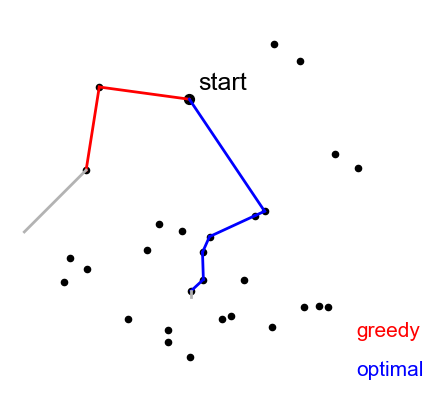

In [13]:
# plot line with dots for cts_in_order and cts_in_order_optimal
%matplotlib inline
fig, ax = plt.subplots(figsize=(5,5))

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 15

# plot the map
for i in range(len(TS['xy'])):
    ax.scatter(TS['xy'][i][0], TS['xy'][i][1], color='black', s=20)

# for i in range(len(TS['xy'])):
#     ax.annotate(i, (TS['xy'][i][0], TS['xy'][i][1]), fontsize=20)


# plot the greedy path
for i in range(len(cts_in_order)-1):
    ax.plot([cts_in_order[i][0], cts_in_order[i+1][0]], [cts_in_order[i][1], cts_in_order[i+1][1]], color='red', linewidth=2, alpha=1)

ax.plot([cts_in_order[-1][0], cts_in_order[-1][0]-R/np.sqrt(2)], [cts_in_order[-1][1], cts_in_order[-1][1]-R/np.sqrt(2)], color='0.7', linewidth=2, alpha=1)
# print distance between two dots
print(np.sqrt((cts_in_order[-1][0]-R/np.sqrt(2) - cts_in_order[-1][0])**2 + (cts_in_order[-1][1]-R/np.sqrt(2) - cts_in_order[-1][1])**2))

# plot the optimal path
for i in range(len(cts_in_order_optimal)-1):
    ax.plot([cts_in_order_optimal[i][0], cts_in_order_optimal[i+1][0]], [cts_in_order_optimal[i][1], cts_in_order_optimal[i+1][1]], color='blue', linewidth=2, alpha=1)

ax.plot([cts_in_order_optimal[-1][0], cts_in_order_optimal[-1][0]], [cts_in_order_optimal[-1][1], cts_in_order_optimal[-1][1]-opt_R], color='0.7', linewidth=2, alpha=1)


# grid off
ax.grid(False)

# remove all borders
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# plot the start point in front of everything
ax.scatter(TS['xy'][0][0], TS['xy'][0][1], color='k', s=50, marker='o', alpha=1)
ax.annotate('start', (TS['xy'][0][0]+10, TS['xy'][0][1]+10), fontsize=18)

# x lim y lim
ax.set_xlim([-220, 220])
ax.set_ylim([-220, 220])

# x ticks and y ticks
ax.set_xticks([])
ax.set_yticks([])

# make axis equal
ax.set_aspect('equal')

# legend
# ax.plot([], [], color='red', linewidth=2, label='greedy')
# ax.plot([], [], color='blue', linewidth=2, label='optimal')

# red and blue text for greedy and optimal
ax.text(0.9, 0.15, 'greedy', transform=ax.transAxes, color='red', fontsize=15)
ax.text(0.9, 0.05, 'optimal', transform=ax.transAxes, color='blue', fontsize=15)

# ax.plot([], [], color='0.7', linewidth=2, label='leftover')
# legend that without box
plt.legend(fontsize=15, loc='lower right', frameon=False)
# save figure
plt.savefig(out_dir + 'greedy_vs_optimal.png')
plt.show()


## Error magnitude histogram|


In [14]:
import matplotlib
matplotlib.rcdefaults()

In [15]:
# compariosn between performance
undo_level = data_choice_level[data_choice_level['condition']==1].copy().reset_index()
basic_level = data_choice_level[data_choice_level['condition']==0].copy().reset_index()

error_magnitude = []
error_magnitude_mean = []
greedy_action = []
error_action = []
leftover = []

num_undo_per_mas = []


for sub in range(100):

    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"])
    dat_sbj_undo  = undo_level[undo_level['subjects']==sub].sort_values(["puzzleID","index"])
    dat_sbj_basic  = basic_level[basic_level['subjects']==sub].sort_values(["puzzleID","index"])

    error_magnitude_puzzle = []
    greedy_action_puzzle = []
    error_action_puzzle = []
    leftover_puzzle = []

    num_undo_per_mas_puzzle = []

    for pzi in np.unique(sc_data_choice_level['puzzleID']):

        TS = map[pzi]

        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()
        dat_sbj_undo_pzi = dat_sbj_undo[dat_sbj_undo['puzzleID'] == pzi].reset_index()
        dat_sbj_basic_pzi = dat_sbj_basic[dat_sbj_basic['puzzleID'] == pzi].reset_index()

        error_magnitude_puzzle.append([np.array(dat_sbj_undo_pzi['currMas'])[-1]-np.array(dat_sbj_undo_pzi['currMas'])[0],
                                  np.array(dat_sbj_basic_pzi['currMas'])[-1]-np.array(dat_sbj_basic_pzi['currMas'])[0]])

        # get distance from TS['xy'][0] to TS['xy'][1:]
        start = np.array(TS['xy'][0])
        # distance = [np.sum(np.sqrt((start - np.array(node))**2)) for node in TS['xy'][1:]]
        distance = [np.sum(np.sqrt((start - np.array(node))**2)) for node in TS['xy']]

        # find the index that is second shortest distance because the first shortest is goint back to itself
        idx = np.argsort(distance)[1]

        # get proportion of data_sbj_undo_pzi['choice'][1] == idx
        greedy_action_puzzle.append([np.double(dat_sbj_undo_pzi['choice'][1] == idx),
                                     np.double(dat_sbj_basic_pzi['choice'][1] == idx)])

        # get proportion of data_sbj_undo_pzi['currMas'][1] is smaller than data_sbj_undo_pzi['currMas'][0]
        error_action_puzzle.append([np.double(dat_sbj_undo_pzi['currMas'][1] < dat_sbj_undo_pzi['currMas'][0]),
                                    np.double(dat_sbj_basic_pzi['currMas'][1] < dat_sbj_basic_pzi['currMas'][0])])

        leftover_puzzle.append([np.array(dat_sbj_undo_pzi['leftover'])[-1], np.array(dat_sbj_basic_pzi['leftover'])[-1]])

        # append number of undos and puzzle MAS
        num_undo_per_mas_puzzle.append([np.array(dat_sbj_undo_pzi['undo']).sum(), dat_sbj_undo_pzi['currMas'][0]])

    # extend point_loss
    hist_undo = np.histogram(np.array(error_magnitude_puzzle)[:,0], bins=[-np.inf, *np.arange(-4,1,1)])[0].astype(dtype=np.float32)
    hist_undo /= hist_undo.sum()
    hist_basic = np.histogram(np.array(error_magnitude_puzzle)[:,1], bins=[-np.inf, *np.arange(-4,1,1)])[0].astype(dtype=np.float32)
    hist_basic /= hist_basic.sum()

    error_magnitude.append([*hist_undo, *hist_basic])

    # append mean of greedy_action_puzzle, error_action_puzzle
    greedy_action.append(np.mean(greedy_action_puzzle, axis=0))
    error_action.append(np.mean(error_action_puzzle, axis=0))
    error_magnitude_mean.append([np.mean(np.array(error_magnitude_puzzle)[:,0]),np.mean(np.array(error_magnitude_puzzle)[:,1])])
    leftover.append(np.mean(leftover_puzzle, axis=0))

    # append number of undos and puzzle MAS
    num_undo_per_mas.append(num_undo_per_mas_puzzle)


greedy_action = np.array(greedy_action)
error_action = np.array(error_action)
error_magnitude = np.array(error_magnitude)
error_magnitude_mean = np.array(error_magnitude_mean)
leftover = np.array(leftover)

num_undo_per_mas = np.array(num_undo_per_mas)


## number of undos per mas

In [16]:
# calculate for each subject
num_undo_mas_persub =[]
for sub in range(100):
    num_undo_mas_persub_mas = []
    for j in range(7,13):
        # if num_undo_per_mas[sub,:,1] == j:
        num_undo_mas_persub_mas.append(num_undo_per_mas[sub,num_undo_per_mas[sub,:,1] == j,0].mean())
    num_undo_mas_persub.append(num_undo_mas_persub_mas)
num_undo_mas_persub = np.array(num_undo_mas_persub)

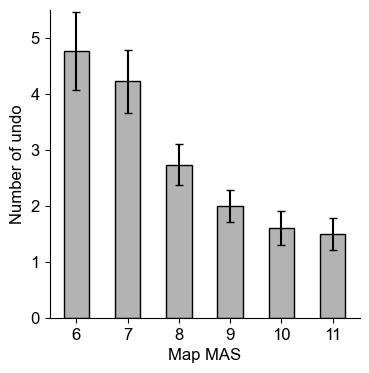

In [17]:
%matplotlib inline

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
plt.figure(figsize=(4,4))

# plot bar of num_undo_mas_persub
plt.bar(np.arange(6,12,1), num_undo_mas_persub.mean(axis=0), width=0.5, color='0.7', alpha=1, edgecolor='k', yerr=num_undo_mas_persub.std(axis=0)/np.sqrt(100), capsize=3)

# x and y label
plt.xlabel('Map MAS')
plt.ylabel('Number of undo')

# set x and y limit
plt.ylim([0, 5.5])

# set xticks and yticks
plt.xticks(np.arange(6,12,1))
plt.yticks(np.arange(0,6,1))

sns.despine()

# save
plt.savefig( out_dir + '/num_undo_per_mas.png', bbox_inches='tight', transparent=True)


## error magnitude

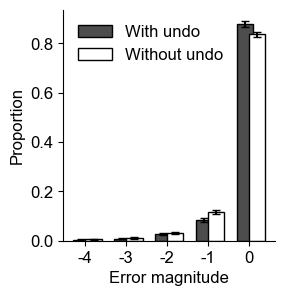

In [18]:
%matplotlib inline
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
# numpy hist for point_loss[:,0]

# plot bar plot of hist_undo
plt.bar(np.arange(-0.1,4.8,1), error_magnitude[:,:5].mean(axis=0), width=0.4, color='0.3', alpha=1, label='With undo', edgecolor='k')
# plot error bar
plt.errorbar(np.arange(-0.1,4.8,1), error_magnitude[:,:5].mean(axis=0), yerr=error_magnitude[:,:5].std(axis=0)/np.sqrt(100), fmt='none', color='k', capsize=3)

# plot bar plot of hist_basic
plt.bar(np.arange(0.2,5.2,1), error_magnitude[:,5:].mean(axis=0), width=0.4, color='1', alpha=1, label='Without undo', edgecolor='k')
# plot error bar
plt.errorbar(np.arange(0.2,5.2,1), error_magnitude[:,5:].mean(axis=0), yerr=error_magnitude[:,5:].std(axis=0)/np.sqrt(100), fmt='none', color='k', capsize=3)


# Y label
plt.ylabel('Proportion')
# X label
plt.xlabel('Error magnitude')

# plt.legend that without box
plt.legend(frameon=False)

# delete top and right frame using plt
sns.despine()

# set xticks
plt.xticks(np.arange(0,5,1), np.arange(-4,1,1))

# save figure
plt.savefig(out_dir + '/error_magnitude.png', dpi=300, bbox_inches='tight')
plt.show()



In [19]:
# ttest_ind for error_magnitude_mean
from scipy.stats import ttest_ind, wilcoxon

stat, p = ttest_ind(error_magnitude_mean[:,0], error_magnitude_mean[:,1])
stat, p = wilcoxon(error_magnitude_mean[:,0], error_magnitude_mean[:,1])

In [20]:
print(stat)
print(p)

618.5
1.5103176165934075e-10


In [21]:
error_magnitude_mean = -error_magnitude_mean

p = 0.000


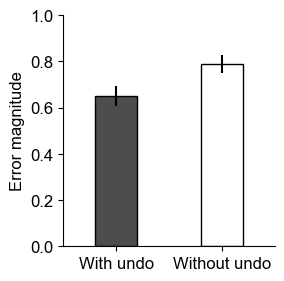

In [22]:
# plot of leftover
%matplotlib inline

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.bar(0, np.mean(error_magnitude_mean[:,0]), yerr=np.std(error_magnitude_mean[:,0])/np.sqrt(100), color='0.3', edgecolor = 'k', width=0.4)
plt.bar(1, np.mean(error_magnitude_mean[:,1]), yerr=np.std(error_magnitude_mean[:,1])/np.sqrt(100), color='1', edgecolor = 'k', width=0.4)

# plt.bar([0,1], np.mean(leftover, axis=0), yerr=np.std(leftover, axis=0)/np.sqrt(100),color=[.7,.7,.7], edgecolor = 'k',)
# plt.xticks([0,1], ['undo', 'basic'])
plt.xticks([0,1], ['With undo', 'Without undo'])
# plt.title('leftover')
plt.xlim(-0.5, 1.5)

plt.ylim(0,1)

plt.ylabel('Error magnitude')

# remove top and right frame
sns.despine()

# text that says about the p value
# plt.text(0.5, 0.95, 'p = %.3f' % p, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# print p value
print('p = %.3f' % p)

# save figure
plt.savefig(out_dir + '/errormagnitude_bar.png', dpi=300, bbox_inches='tight')
plt.show()

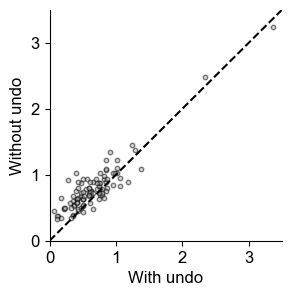

In [23]:
# scatter plot of time taken
%matplotlib inline
# set font and font size
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(3,3))

plt.scatter(error_magnitude_mean[:,0], error_magnitude_mean[:,1], color=[.7,.7,.7], s=10, alpha=0.5, edgecolor = 'k')

# get plausible range of x and y and set xlim and ylim
plt.xlim([0, 3.5])
plt.ylim([0, 3.5])

# set xand y label
plt.xlabel('With undo')
plt.ylabel('Without undo')

# title
# plt.title('Error magnitude')


# remove top and right frame
sns.despine()

# mid line
plt.plot([0,3.5],[0,3.5], 'k--')

# save figure
plt.savefig(out_dir + '/scatter_error_magnitude.png', dpi=300, bbox_inches='tight')


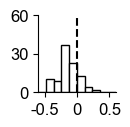

In [24]:
# small histogram around diagonal line
%matplotlib inline

plt.figure(figsize=(1,1))

plt.hist(error_magnitude_mean[:,0]-error_magnitude_mean[:,1], bins=np.linspace(-0.6,0.6,11), color='w', alpha=1, label='With undo', edgecolor='k')
# center line of histogram at x = 0
plt.plot([0,0],[0,60], 'k--')

# remove top and right frame
sns.despine()

# set x and y lim
plt.xlim([-0.6,0.6])
plt.ylim([0,60])

# set x and y ticks
plt.xticks([-0.5,0,0.5])
# set xtickslabel
plt.gca().set_xticklabels(['-0.5','0','0.5'])
plt.yticks([0,30,60])

# save figure
plt.savefig(out_dir + '/hist_error_magnitude.png', dpi=300, bbox_inches='tight')


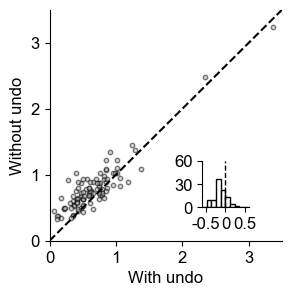

In [25]:
# scatter plot of time taken
%matplotlib inline
# set font and font size
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(3,3))

plt.scatter(error_magnitude_mean[:,0], error_magnitude_mean[:,1], color=[.7,.7,.7], s=10, alpha=0.5, edgecolor = 'k')

# get plausible range of x and y and set xlim and ylim
plt.xlim([0, 3.5])
plt.ylim([0, 3.5])

# set xand y label
plt.xlabel('With undo')
plt.ylabel('Without undo')

# title
# plt.title('Error magnitude')


# remove top and right frame
sns.despine()

# mid line
plt.plot([0,3.5],[0,3.5], 'k--')
# make inset and include hist_error_magnitude
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(plt.gca(), width="20%", height="20%", loc=4, borderpad=2)
axins.hist(error_magnitude_mean[:,0]-error_magnitude_mean[:,1], bins=np.linspace(-0.6,0.6,11), color='w', alpha=1, label='With undo', edgecolor='k')
# center line of histogram at x = 0
axins.plot([0,0],[0,60], 'k--', linewidth=1)

# set x and y lim of axins
axins.set_xlim([-0.6,0.6])
axins.set_ylim([0,60])

# set x and y ticks of axins
axins.set_xticks([-0.5,0,0.5])

# set xtickslabel of axins
axins.set_xticklabels(['-0.5','0','0.5'])
axins.set_yticks([0,30,60])


# remove top and right frame
sns.despine()

# save figure
plt.savefig(out_dir + '/scatter_error_magnitude_inset.png', dpi=300, bbox_inches='tight')


## leftover

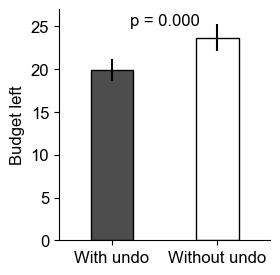

In [26]:
# plot of leftover
%matplotlib inline

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.bar(0, np.mean(leftover[:,0]), yerr=np.std(leftover[:,0])/np.sqrt(100), color='0.3', edgecolor = 'k', width=0.4)
plt.bar(1, np.mean(leftover[:,1]), yerr=np.std(leftover[:,1])/np.sqrt(100), color='1', edgecolor = 'k', width=0.4)

# plt.bar([0,1], np.mean(leftover, axis=0), yerr=np.std(leftover, axis=0)/np.sqrt(100),color=[.7,.7,.7], edgecolor = 'k',)
# plt.xticks([0,1], ['undo', 'basic'])
plt.xticks([0,1], ['With undo', 'Without undo'])
# plt.title('leftover')
plt.xlim(-0.5, 1.5)

plt.ylim(0,27)

plt.ylabel('Budget left')

# remove top and right frame
sns.despine()

# text that says about the p value
plt.text(0.5, 0.95, 'p = %.3f' % p, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)


# save figure
plt.savefig(out_dir + '/leftover_bar.png', dpi=300, bbox_inches='tight')
plt.show()

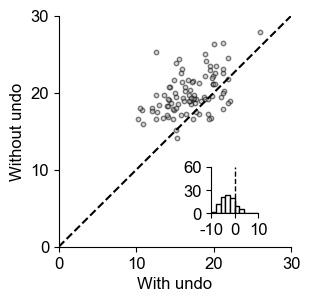

In [27]:
%matplotlib inline
# set font and font size
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(3,3))

plt.scatter(leftover[:,0], leftover[:,1], color=[.7,.7,.7], s=10, alpha=0.5, edgecolor = 'k')

# get plausible range of x and y and set xlim and ylim
plt.xlim([0, 27])
plt.ylim([0, 27])

# set xand y label
plt.xlabel('With undo')
plt.ylabel('Without undo')

# title
# plt.title('Error magnitude')


# remove top and right frame
sns.despine()

# mid line
plt.plot([0,30],[0,30], 'k--')

# set xticks and yticks
plt.xticks([0,10,20,30])
plt.yticks([0,10,20,30])

# make inset and include hist_error_magnitude
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(plt.gca(), width="20%", height="20%", loc=4, borderpad=2)
axins.hist(leftover[:,0]-leftover[:,1], bins=np.linspace(-10,10,11), color='w', alpha=1, label='With undo', edgecolor='k')
# center line of histogram at x = 0
axins.plot([0,0],[0,60], 'k--', linewidth=1)

# set x and y lim of axins
axins.set_xlim([-10,10])
axins.set_ylim([0,60])

# set x and y ticks of axins
axins.set_xticks([-10,0,10])

# set xtickslabel of axins
axins.set_xticklabels(['-10','0','10'])
axins.set_yticks([0,30,60])


# remove top and right frame
sns.despine()

# save figure
plt.savefig(out_dir + '/scatter_leftover_inset.png', dpi=300, bbox_inches='tight')


## RTs

In [28]:
undo_level = data_choice_level[data_choice_level['condition']==1].copy().reset_index()
basic_level = data_choice_level[data_choice_level['condition']==0].copy().reset_index()

time_taken =[]
first_RT = []

for sub in range(100):

    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"])
    dat_sbj_undo  = undo_level[undo_level['subjects']==sub].sort_values(["puzzleID","index"])
    dat_sbj_basic  = basic_level[basic_level['subjects']==sub].sort_values(["puzzleID","index"])

    time_taken_puzzle = []
    first_RT_puzzle = []

    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID']==pzi]
        dat_sbj_undo_pzi = dat_sbj_undo[dat_sbj_undo['puzzleID']==pzi]
        dat_sbj_basic_pzi = dat_sbj_basic[dat_sbj_basic['puzzleID']==pzi]

        time_taken_puzzle.append([np.sum(dat_sbj_undo_pzi['RT'][1:])+np.sum(dat_sbj_undo_pzi['undoRT']), np.sum(dat_sbj_basic_pzi['RT'][1:]) ])
        first_RT_puzzle.append([(dat_sbj_undo_pzi['RT'].iloc[1]), (dat_sbj_basic_pzi['RT'].iloc[1]) ])

    time_taken.append(time_taken_puzzle)
    first_RT.append(first_RT_puzzle)

time_taken = np.array(time_taken)
first_RT = np.array(first_RT)


## time taken

In [29]:
time_taken_ = np.array(time_taken).reshape((-1,2))/1000

In [30]:
# ttest_ind
from scipy.stats import ttest_ind
stat,p=ttest_ind(time_taken_[:,0], time_taken_[:,1])
print('stat=%.3f, p=%.3f' % (stat, p))

stat=20.330, p=0.000


stat=20.330, p=0.000


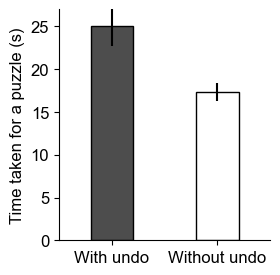

In [31]:
# bar plot
%matplotlib inline


plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.bar(0, np.mean(time_taken_[:,0]), yerr=np.std(time_taken_[:,0])/np.sqrt(100), color='0.3', edgecolor = 'k', width=0.4)
plt.bar(1, np.mean(time_taken_[:,1]), yerr=np.std(time_taken_[:,1])/np.sqrt(100), color='1', edgecolor = 'k', width=0.4)

# plt.bar([0,1], np.mean(leftover, axis=0), yerr=np.std(leftover, axis=0)/np.sqrt(100),color=[.7,.7,.7], edgecolor = 'k',)
# plt.xticks([0,1], ['undo', 'basic'])
plt.xticks([0,1], ['With undo', 'Without undo'])
# plt.title('leftover')
plt.xlim(-0.5, 1.5)

plt.ylim(0,27)

plt.ylabel('Time taken for a puzzle (s)')

#statistical test
from scipy.stats import ttest_ind
stat,p=ttest_ind(time_taken_[:,0], time_taken_[:,1])
print('stat=%.3f, p=%.3f' % (stat, p))

# text that says about the p value
# plt.text(0.5, 0.95, 'p = %.3f' % p, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)


# remove top and right frame
sns.despine()

# save figure
plt.savefig(out_dir + '/time_taken_bar.png', dpi=300, bbox_inches='tight')

# save figure
plt.show()

In [32]:
time_taken_mean = time_taken.mean(axis=1)/1000

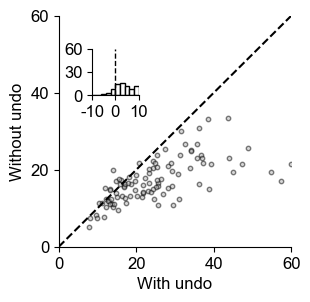

In [33]:
%matplotlib inline
# set font and font size
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(3,3))

plt.scatter(time_taken_mean[:,0], time_taken_mean[:,1], color=[.7,.7,.7], s=10, alpha=0.5, edgecolor = 'k')

# get plausible range of x and y and set xlim and ylim
plt.xlim([0, 27])
plt.ylim([0, 27])

# set xand y label
plt.xlabel('With undo')
plt.ylabel('Without undo')

# title
# plt.title('Error magnitude')


# remove top and right frame
sns.despine()

# mid line
plt.plot([0,60],[0,60], 'k--')

# set xticks and yticks
plt.xticks([0,20,40,60])
plt.yticks([0,20,40,60])

# make inset and include hist_error_magnitude
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(plt.gca(), width="20%", height="20%", loc=2, borderpad=2)
axins.hist(time_taken_mean[:,0]-time_taken_mean[:,1], bins=np.linspace(-10,10,11), color='w', alpha=1, label='With undo', edgecolor='k')
# center line of histogram at x = 0
axins.plot([0,0],[0,60], 'k--', linewidth=1)

# set x and y lim of axins
axins.set_xlim([-10,10])
axins.set_ylim([0,60])

# set x and y ticks of axins
axins.set_xticks([-10,0,10])

# set xtickslabel of axins
axins.set_xticklabels(['-10','0','10'])
axins.set_yticks([0,30,60])


# remove top and right frame
sns.despine()

# save figure
plt.savefig(out_dir + '/scatter_time_taken_inset.png', dpi=300, bbox_inches='tight')


## first RT

In [34]:
first_RT_ = np.array(first_RT).reshape((-1,2))/1000

In [35]:
# ttest_ind
from scipy.stats import ttest_ind
stat,p=ttest_ind(first_RT_[:,0], first_RT_[:,1])
print('stat=%.3f, p=%.3f' % (stat, p))


stat=-5.825, p=0.000


stat=-5.825, p=0.000


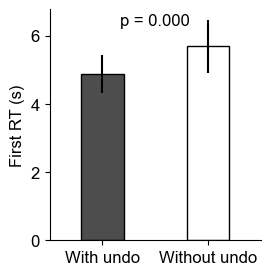

In [36]:
# bar plot
%matplotlib inline


plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.bar(0, np.mean(first_RT_[:,0]), yerr=np.std(first_RT_[:,0])/np.sqrt(100), color='0.3', edgecolor = 'k', width=0.4)
plt.bar(1, np.mean(first_RT_[:,1]), yerr=np.std(first_RT_[:,1])/np.sqrt(100), color='1', edgecolor = 'k', width=0.4)

# plt.bar([0,1], np.mean(leftover, axis=0), yerr=np.std(leftover, axis=0)/np.sqrt(100),color=[.7,.7,.7], edgecolor = 'k',)
# plt.xticks([0,1], ['undo', 'basic'])
plt.xticks([0,1], ['With undo', 'Without undo'])
# plt.title('leftover')
plt.xlim(-0.5, 1.5)


plt.ylabel('First RT (s)')

#statistical test
from scipy.stats import ttest_ind
stat,p=ttest_ind(first_RT_[:,0], first_RT_[:,1])
print('stat=%.3f, p=%.3f' % (stat, p))


# remove top and right frame
sns.despine()

# text that says about the p value
plt.text(0.5, 0.95, 'p = %.3f' % p, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

# save figure
plt.savefig(out_dir + '/bar_first_RT.png', dpi=300, bbox_inches='tight')
# save figure
plt.show()

In [37]:
first_RT_mean = np.mean(first_RT, axis=1)/1000

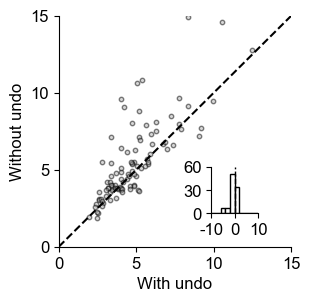

In [38]:
# scatter plot of time taken
%matplotlib inline
# set font and font size
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(3,3))

plt.scatter(first_RT_mean[:,0], first_RT_mean[:,1], color=[.7,.7,.7], s=10, alpha=0.5, edgecolor = 'k')

# get plausible range of x and y and set xlim and ylim
plt.xlim([0, 15])
plt.ylim([0, 15])

# set xand y label
plt.xlabel('With undo')
plt.ylabel('Without undo')

# title
# plt.title('Error magnitude')


# remove top and right frame
sns.despine()

# mid line
plt.plot([0,15],[0,15], 'k--')

# set xticks and yticks
plt.xticks([0,5,10,15])
plt.yticks([0,5,10,15])

# make inset and include hist_error_magnitude
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(plt.gca(), width="20%", height="20%", loc=4, borderpad=2)
axins.hist(first_RT_mean[:,0]-first_RT_mean[:,1], bins=np.linspace(-10,10,11), color='w', alpha=1, label='With undo', edgecolor='k')
# center line of histogram at x = 0
axins.plot([0,0],[0,60], 'k--', linewidth=1)

# set x and y lim of axins
axins.set_xlim([-10,10])
axins.set_ylim([0,60])

# set x and y ticks of axins
axins.set_xticks([-10,0,10])

# set xtickslabel of axins
axins.set_xticklabels(['-10','0','10'])
axins.set_yticks([0,30,60])


# remove top and right frame
sns.despine()

# save figure
plt.savefig(out_dir + '/scatter_firstRTmean_inset.png', dpi=300, bbox_inches='tight')


## calculate time for a puzzle that is matched

In [39]:
undo_level = data_choice_level[data_choice_level['condition'] == 1].copy().reset_index()
basic_level = data_choice_level[data_choice_level['condition'] == 0].copy().reset_index()

time_taken_0undo = []
first_RT_0undo = []

for sub in range(100):

    dat_sbj = sc_data_choice_level[sc_data_choice_level['subjects'] == sub].sort_values(["puzzleID", "index"])
    dat_sbj_undo = undo_level[undo_level['subjects'] == sub].sort_values(["puzzleID", "index"])
    dat_sbj_basic = basic_level[basic_level['subjects'] == sub].sort_values(["puzzleID", "index"])

    time_taken_0undo_puzzle = []
    first_RT_0undo_puzzle = []

    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi]
        dat_sbj_undo_pzi = dat_sbj_undo[dat_sbj_undo['puzzleID'] == pzi]
        dat_sbj_basic_pzi = dat_sbj_basic[dat_sbj_basic['puzzleID'] == pzi]

        # check if dat_sbj_pzi['undo'].sum() is 0
        if dat_sbj_pzi['undo'].sum() == 0:
            time_taken_0undo_puzzle.append([np.sum(dat_sbj_undo_pzi['RT'][1:])/1000, np.sum(dat_sbj_basic_pzi['RT'][1:])/1000])
            first_RT_0undo_puzzle.append([(dat_sbj_undo_pzi['RT'].iloc[1])/1000, (dat_sbj_basic_pzi['RT'].iloc[1])/1000])
        else:
            #append nan
            time_taken_0undo_puzzle.append([np.nan, np.nan])
            first_RT_0undo_puzzle.append([np.nan, np.nan])

    time_taken_0undo.append(np.nanmean(time_taken_0undo_puzzle, axis=0))
    first_RT_0undo.append(np.nanmean(first_RT_0undo_puzzle, axis=0))

time_taken_0undo = np.array(time_taken_0undo)
first_RT_0undo = np.array(first_RT_0undo)


/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_97199/2722325208.py:30: RuntimeWarning: Mean of empty slice
  time_taken_0undo.append(np.nanmean(time_taken_0undo_puzzle, axis=0))
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_97199/2722325208.py:31: RuntimeWarning: Mean of empty slice
  first_RT_0undo.append(np.nanmean(first_RT_0undo_puzzle, axis=0))


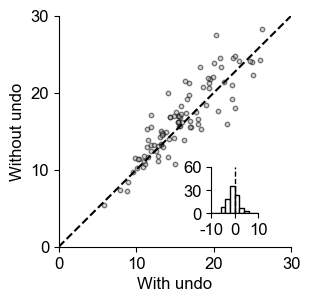

In [40]:
%matplotlib inline
# set font and font size
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(3,3))

plt.scatter(time_taken_0undo[:,0], time_taken_0undo[:,1], color=[.7,.7,.7], s=10, alpha=0.5, edgecolor = 'k')

# get plausible range of x and y and set xlim and ylim
plt.xlim([0, 27])
plt.ylim([0, 27])

# set xand y label
plt.xlabel('With undo')
plt.ylabel('Without undo')

# title
# plt.title('Error magnitude')


# remove top and right frame
sns.despine()

# mid line
plt.plot([0,30],[0,30], 'k--')

# set xticks and yticks
plt.xticks([0,10,20,30])
plt.yticks([0,10,20,30])

# make inset and include hist_error_magnitude
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(plt.gca(), width="20%", height="20%", loc=4, borderpad=2)
axins.hist(time_taken_0undo[:,0]-time_taken_0undo[:,1], bins=np.linspace(-10,10,11), color='w', alpha=1, label='With undo', edgecolor='k')
# center line of histogram at x = 0
axins.plot([0,0],[0,60], 'k--', linewidth=1)

# set x and y lim of axins
axins.set_xlim([-10,10])
axins.set_ylim([0,60])

# set x and y ticks of axins
axins.set_xticks([-10,0,10])

# set xtickslabel of axins
axins.set_xticklabels(['-10','0','10'])
axins.set_yticks([0,30,60])


# remove top and right frame
sns.despine()

# save figure
plt.savefig(out_dir + '/scatter_time_taken_0undo_inset.png', dpi=300, bbox_inches='tight')


# Results in different city (undo target)

## different city (undo target)

In [41]:
undo_same_diff = []

for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"])
    undo_same_diff_puzzle = []
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        same_puzzle = 0
        diff_puzzle = 0

        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()

        lastUndo_idx = dat_sbj_pzi[dat_sbj_pzi["lastUndo"]==1].index

        idxx = np.array(dat_sbj_pzi["choice"][lastUndo_idx-1]) != np.array(dat_sbj_pzi["choice"][lastUndo_idx+1])
        diff_puzzle += np.sum(idxx)
        idxx = np.array(dat_sbj_pzi["choice"][lastUndo_idx-1]) == np.array(dat_sbj_pzi["choice"][lastUndo_idx+1])
        same_puzzle += np.sum(idxx)

        undo_same_diff_puzzle.append([same_puzzle, diff_puzzle])
    undo_same_diff_puzzle =  np.array(undo_same_diff_puzzle)
    undo_same_diff_puzzle =  np.sum(undo_same_diff_puzzle,axis=0)

    if np.sum(undo_same_diff_puzzle)==0:
        print(sub) # who does not undo

    undo_same_diff.append(undo_same_diff_puzzle)

undo_same_diff = np.array(undo_same_diff)

5
26
42
47
56
64
71
80
86
98


In [42]:
# exclude some never undoing subjects
undo_same_diff = undo_same_diff[np.where(np.sum(np.array(undo_same_diff),axis=1)!=0),:]
undo_same_diff = undo_same_diff.squeeze()
undo_same_diff_p = undo_same_diff/ np.sum(undo_same_diff,axis = 1)[:,None]

In [43]:
np.mean(undo_same_diff_p,axis=0)

array([0.11857317, 0.88142683])

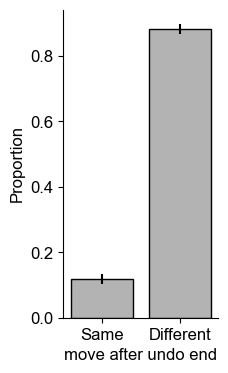

In [44]:
%matplotlib inline

plt.figure(figsize=(2,4))
plt.bar(range(2), np.mean(undo_same_diff_p,axis=0),
        color=[.7,.7,.7], edgecolor = 'k',
        yerr=np.std(undo_same_diff_p,axis = 0)/np.sqrt(undo_same_diff_p.shape[0]))
plt.xticks([0,1], ['Same','Different'])
plt.ylabel('Proportion')
# remove right and top frame
sns.despine()

plt.xlabel('move after undo end')

# save figure
plt.savefig(out_dir + '/undo_same_diff.png', dpi=300, bbox_inches='tight')

In [45]:
#wilcoxon signed-rank test
stat, p = wilcoxon(undo_same_diff_p[:,0], undo_same_diff_p[:,1])
print(stat)
print(p)

82.0
2.101861284114228e-15


## ( same x different ) x ( better, equally good, worse )

In [46]:
sub = 0
dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"])
pzi = 1

In [47]:
undo_same_diff = []
undo_same_diff_weqb = []

for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"])
    same_puzzle = 0
    same_worse_eq_better = np.array([0,0,0])
    diff_puzzle = 0
    diff_worse_eq_better = np.array([0,0,0])
    for pzi in np.unique(sc_data_choice_level['puzzleID']):

        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()

        lastUndo_idx = dat_sbj_pzi[dat_sbj_pzi["lastUndo"]==1].index

        idxx_diff = np.array(dat_sbj_pzi["choice"][lastUndo_idx-1]) != np.array(dat_sbj_pzi["choice"][lastUndo_idx+1])
        diff_puzzle += np.sum(idxx_diff)

        idxx_same = np.array(dat_sbj_pzi["choice"][lastUndo_idx-1]) == np.array(dat_sbj_pzi["choice"][lastUndo_idx+1])
        same_puzzle += np.sum(idxx_same)

        mas_gain = np.array(dat_sbj_pzi["currMas"][lastUndo_idx+1]) - np.array(dat_sbj_pzi["currMas"][lastUndo_idx-1])

        idxx_w  = mas_gain < 0
        idxx_eq = mas_gain == 0
        idxx_b  = mas_gain > 0

        # find intersection between np.where(idxx_diff) and np.where(idxx_w), np.where(idxx_eq), np.where(idxx_b)
        idxx_diff_w = np.intersect1d(np.where(idxx_diff)[0], np.where(idxx_w)[0])
        idxx_diff_eq = np.intersect1d(np.where(idxx_diff)[0], np.where(idxx_eq)[0])
        idxx_diff_b = np.intersect1d(np.where(idxx_diff)[0], np.where(idxx_b)[0])

        diff_worse_eq_better += np.array([len(idxx_diff_w), len(idxx_diff_eq), len(idxx_diff_b)])

        # find intersection between np.where(idxx_same) and np.where(idxx_w), np.where(idxx_eq), np.where(idxx_b)
        idxx_same_w = np.intersect1d(np.where(idxx_same)[0], np.where(idxx_w)[0])
        idxx_same_eq = np.intersect1d(np.where(idxx_same)[0], np.where(idxx_eq)[0])
        idxx_same_b = np.intersect1d(np.where(idxx_same)[0], np.where(idxx_b)[0])

        same_worse_eq_better += np.array([len(idxx_same_w), len(idxx_same_eq), len(idxx_same_b)])

    undo_same_diff_puzzle =  np.array([same_puzzle, diff_puzzle])
    undo_same_diff_weqb_puzzle = np.array([*same_worse_eq_better, *diff_worse_eq_better])

    if np.sum(undo_same_diff_puzzle)==0:
        print(sub) # who does not undo

    undo_same_diff.append(undo_same_diff_puzzle)
    undo_same_diff_weqb.append(undo_same_diff_weqb_puzzle)

undo_same_diff = np.array(undo_same_diff)
undo_same_diff_weqb = np.array(undo_same_diff_weqb)

5
26
42
47
56
64
71
80
86
98


In [48]:
# exclude some never undoing subjects
undo_same_diff_weqb = undo_same_diff_weqb[np.where(np.sum(np.array(undo_same_diff_weqb),axis=1)!=0),:]
undo_same_diff_weqb = undo_same_diff_weqb.squeeze()
undo_same_diff_weqb_p = undo_same_diff_weqb/ np.sum(undo_same_diff_weqb,axis = 1)[:,None]

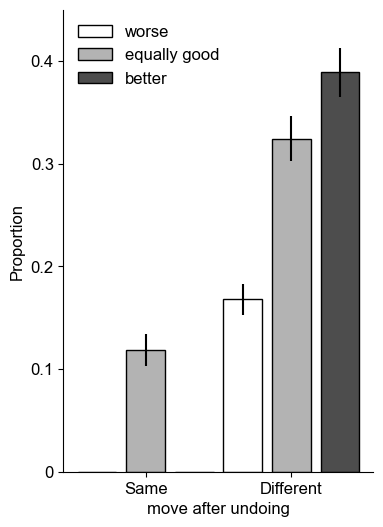

In [71]:
%matplotlib inline

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
# bar plot for undo_same_diff_weqb

fig, ax = plt.subplots(1,1,figsize=(4,4))
colors = ['w','0.7','0.3']
for each in range(3):
    ax.bar(np.arange(2)*3+each, np.mean(undo_same_diff_weqb_p[:, np.arange(2)*3+each],axis=0), yerr = np.std(undo_same_diff_weqb_p[:, np.arange(2)*3+each],axis=0)/np.sqrt(undo_same_diff_weqb[:, np.arange(2)*3+each].shape[0]), color = colors[each],edgecolor = 'k')


# ax.bar(np.arange(6), np.mean(undo_same_diff_weqb_p,axis=0), yerr = np.std(undo_same_diff_weqb_p,axis=0)/np.sqrt(undo_same_diff_weqb.shape[0]), color = ['w','0.5','k'],edgecolor = 'k')
sns.despine()

# ax.set_xticks(np.arange(6))
# ax.set_xticklabels(['','Same','','','Different',''])

ax.set_xticks([1,4])
ax.set_xticklabels(['Same','Different'])

# set y lim
ax.set_ylim([0,0.45])

# set y ticks
ax.set_yticks(np.arange(0,0.5,0.1))
# set ytickslabel in string
ax.set_yticklabels(['0','0.1','0.2','0.3','0.4'])

# legend that says worse, equally good, better, without bounding box
ax.legend(['worse','equally good','better'],loc='upper left', frameon=False)

ax.set_xlabel('move after undoing')
ax.set_ylabel('Proportion')

# save figure
plt.savefig(out_dir + '/figure_worse_better_with_same_diff.png', dpi=300, bbox_inches='tight')


# Overlapped sequence

### overlapped sequence from all of the prev seqs.

In [50]:
import difflib

def get_overlap(s1, s2):
    #
    s = difflib.SequenceMatcher(None, s1, s2)
    pos_a, pos_b, size = s.find_longest_match(0, len(s1), 0, len(s2))
    return s1[pos_a:pos_a+size]

def get_overlaplist(l1,l2,minlen=1):
    # return overlaping numbers in sequence
    matched_seq = []
    for i1 in range(len(l1)):
#         print('l1:{}'.format(i1))
        matches = [i2 for i2 in range(len(l2)) if l2[i2] == l1[i1]]
#         print(matches)
        for m in matches:
            matched_seq_ = []
            i_a = 0
            while ((i1+i_a)<len(l1)) and ((m+i_a)< len(l2)):
                if l1[i1+i_a]==l2[m+i_a]:
                    matched_seq_.append(l1[i1+i_a])
                    i_a += 1
                else:
                    break
            matched_seq.append(matched_seq_)

    idx = np.argsort([len(seq) for seq in matched_seq])[::-1]
#     print(idx)

    seqs_ = []
    for i in idx:
        if len(seqs_) == 0:
            seqs_.append(matched_seq[i])
        else:
            if not np.any([np.all(np.isin(matched_seq[i],seq)) for seq in seqs_]):
                seqs_.append(matched_seq[i])
    matched_seq = seqs_.copy()
    idx = np.argsort([len(seq) for seq in matched_seq])
    seqs_ = []
    for i in idx:
        if len(seqs_) == 0:
            seqs_.append(matched_seq[i])
        else:
            if not np.any([np.all(np.isin(matched_seq[i],seq)) for seq in seqs_]):
                seqs_.append(matched_seq[i])

    seqs = []
    for seq in seqs_:
#         print(len(seq))
        if not len(seq)<minlen:
            seqs.append(seq)

    return seqs

def trimmer(matched_seq,minlen=1):
    idx = np.argsort([len(seq) for seq in matched_seq])[::-1]
#     print(idx)

    seqs_ = []
    for i in idx:
        if len(seqs_) == 0:
            seqs_.append(matched_seq[i])
        else:
            if not np.any([np.all(np.isin(matched_seq[i],seq)) for seq in seqs_]):
                seqs_.append(matched_seq[i])
    matched_seq = seqs_.copy()
    idx = np.argsort([len(seq) for seq in matched_seq])
    seqs_ = []
    for i in idx:
        if len(seqs_) == 0:
            seqs_.append(matched_seq[i])
        else:
            if not np.any([np.all(np.isin(matched_seq[i],seq)) for seq in seqs_]):
                seqs_.append(matched_seq[i])

    seqs = []
    for seq in seqs_:
#         print(len(seq))
        if not len(seq)<minlen:
            seqs.append(seq)

    return seqs

In [51]:
minlen_of_seq = 0

overlap_seq_inorder = []
overlap_seq_inorder_inlen=[]
overlap_seq_inorder_num = []
overlap_seq_inorder_num_inlen=[]

overlap_seq_inorder_norm = []
overlap_seq_inorder_num_norm = []
overlap_seq_inorder_norm_p = []
overlap_seq_inorder_num_norm_p = []


length_undone = []
length_undone_p = []

currmas = []
currmas_inlen=[]

currmas_num = []
currmas_num_inlen=[]

length_seq = []
length_seq_persub_p = []
length_num_persub_p = []

length_seq_persub = []
length_num_persub = []

mas_undone_tot= []
length_undone_tot=[]

overlap_seq_inorder_norm_tot = []
overlap_seq_inorder_num_norm_tot = []
length_undone_norm_tot = []

for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"])
    overlap_seq_inorder_for_puzzle = []
    overlap_seq_inorder_inlen_for_puzzle=[]

    overlap_seq_inorder_num_for_puzzle = []
    overlap_seq_inorder_num_inlen_for_puzzle=[]

    length_undone_norm_for_puzzle = []
    overlap_seq_inorder_norm_for_puzzle = []
    overlap_seq_inorder_num_norm_for_puzzle = []

    length_undone_for_puzzle = []
    length_undone_for_puzzle_p = []

    currmas_for_puzzle = []
    currmas_inlen_for_puzzle=[]

    length_seq_persub_for_puzzle = []
    length_num_persub_for_puzzle = []
    currmas_num_for_puzzle = []
    currmas_num_inlen_for_puzzle=[]

    mas_undone_for_puzzle = []

    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()

        firstUndo_idx = dat_sbj_pzi[dat_sbj_pzi["firstUndo"]==1].index
        path_bf_undo = dat_sbj_pzi["currMas"][firstUndo_idx-1] # the mas of the state before undo

        lastUndo_idx = dat_sbj_pzi[dat_sbj_pzi["lastUndo"]==1].index
        path_af_undo = dat_sbj_pzi["currMas"][lastUndo_idx+1] # the mas of the state after undo

        submit_idx =  pd.Int64Index([len(dat_sbj_pzi)-1])


        if len(firstUndo_idx)>0:
            if len(firstUndo_idx)==1: #
                seq_bf = dat_sbj_pzi["path"][firstUndo_idx-1]
                seq_af = dat_sbj_pzi["path"][submit_idx]
                seq_im = dat_sbj_pzi["path"][lastUndo_idx]
                currmas_bf = dat_sbj_pzi["currMas"][lastUndo_idx-1]
                currmas_af = dat_sbj_pzi["currMas"][lastUndo_idx+1]

            else:
                seq_bf = dat_sbj_pzi["path"][firstUndo_idx-1]
                t_idx = (firstUndo_idx[1:]-1).to_list()
                t_idx.append(submit_idx.item())
                seq_af = dat_sbj_pzi["path"][t_idx]
                seq_im = dat_sbj_pzi["path"][lastUndo_idx]
                currmas_bf = dat_sbj_pzi["currMas"][lastUndo_idx-1]
                currmas_af = dat_sbj_pzi["currMas"][lastUndo_idx+1]

            seq_im = seq_im.reset_index()
            pathStr_im = [seq_im.loc[i].path.strip('[').strip(']') for i in range(len(seq_im))]
            pathList_im = [[int(i) for i in pathStr_im[j].split(', ')]  for j in range(len(pathStr_im))]
            pathStr_im = [" ".join([str(a) for a in pathList_im[j]]) for j in range(len(seq_im))]

            seq_bf = seq_bf.reset_index()
            pathStr_bf = [seq_bf.loc[i].path.strip('[').strip(']') for i in range(len(seq_bf))]
            pathList_bf = [[int(i) for i in pathStr_bf[j].split(', ')]  for j in range(len(pathStr_bf))]
            pathStr_bf = [" ".join([str(a) for a in pathList_bf[j]]) for j in range(len(seq_bf))]

            seq_af = seq_af.reset_index()
            pathStr_af = [seq_af.loc[i].path.strip('[').strip(']') for i in range(len(seq_af))]
            pathList_af = [[int(i) for i in pathStr_af[j].split(', ')]  for j in range(len(pathStr_af))]
            pathStr_af = [" ".join([str(a) for a in pathList_af[j]]) for j in range(len(seq_af))]

            strarray = [np.setdiff1d([str(i ) for i in pathList_bf[i]],[str(i) for i in pathList_im[i]]).tolist() for i in range(len(pathList_bf))]
            pathList_bfim = [[int(a) for a in strarray[j]] for j in range(len(strarray))]
            # pathList_bfim = [np.setdiff1d(np.array(pathList_bf[i]),np.array(pathList_im[i])).tolist() for i in range(len(pathList_bf))]
            pathStr_bfim = [" ".join([str(a) for a in pathList_bfim[j]]) for j in range(len(pathList_im))]

            strarray = [np.setdiff1d([str(i ) for i in pathList_af[i]],[str(i) for i in pathList_im[i]]).tolist() for i in range(len(pathList_af))]
            pathList_afim = [[int(a) for a in strarray[j]] for j in range(len(strarray))]
            # pathList_afim = [np.setdiff1d(np.array(pathList_af[i]),np.array(pathList_im[i])).tolist() for i in range(len(pathList_af))]
            pathStr_afim = [" ".join([str(a) for a in pathList_afim[j]]) for j in range(len(pathList_im))]

            currmas_dif = np.array(currmas_af) - np.array(currmas_bf)


            overlap_seq_2 = []
            seq_inorder_2 = []
            currmas_dif_2 = []
            overlap_num_city = []
            overlap_seq_foreach = []
            for i in range(len(seq_af)):
                temp = []
                for j in range(i+1):
            #         temp.append(get_overlaplist(pathList_afim[i], pathList_bfim[j]))
                    temptemp = get_overlaplist(pathList_afim[i], pathList_bfim[j])
                    if not len(temptemp)==0:
                        temp.extend(temptemp)

                temp = trimmer(temp)
                if len(temp)==0:
                    temp.append([])

                overlap_num_city_ = 0
                for seq in temp:
                    overlap_num_city_ += len(seq)
                overlap_num_city.append(overlap_num_city_)
                seq_inorder_2.append(temp)

            #     len_seq_inorder_2 = [len(s) for s in temp if len(s)!=0]
                len_seq_inorder_2 =[]
                tempcurd = []
                for s in temp:
#                     print('*')
                    if len(s)==0:
                        len_seq_inorder_2.append(0)
                    else:
                        len_seq_inorder_2.append(len(s))
                    tempcurd.append(currmas_dif[i])



                overlap_seq_2.extend(len_seq_inorder_2)
                currmas_dif_2.extend(tempcurd)
                overlap_seq_foreach.append(len_seq_inorder_2)
#                 print(overlap_seq_2)
#                 print(currmas_dif_2)

            # find the index pathList_afim's len is shorter than minlen_of_seq
            idx = [i for i in range(len(pathList_afim)) if len(pathList_afim[i])>minlen_of_seq]

            temp_inorder = np.array([max(seq) for seq in overlap_seq_foreach])/np.array([len(seq) for seq in pathList_afim]).tolist()

            overlap_seq_inorder_norm_for_puzzle.extend(temp_inorder[idx])

            temp_rglssorder = np.array(overlap_num_city)/np.array([len(seq) for seq in pathList_afim]).tolist()

            # find the index pathList_afim's len is shorter than minlen_of_seq

            overlap_seq_inorder_num_norm_for_puzzle.extend(temp_rglssorder[idx])

            length_undone_norm_for_puzzle.extend(np.array([len(seq) for seq in pathList_afim])[idx].tolist())

            # print(np.array(overlap_num_city)/np.array([len(seq) for seq in pathList_afim]))
            # print(np.array([max(seq) for seq in overlap_seq_foreach])/np.array([len(seq) for seq in pathList_afim]))


            overlap_seq_inorder_for_puzzle.append([np.sum(np.array(overlap_seq_2)==0), np.sum(np.array(overlap_seq_2)!=0)])
            overlap_seq_inorder_inlen_for_puzzle.append([np.sum(np.array(overlap_seq_2)==0), np.sum(np.array(overlap_seq_2)==1),
                                                         np.sum(np.array(overlap_seq_2)==2), np.sum(np.array(overlap_seq_2)==3),
                                                         np.sum(np.array(overlap_seq_2)==4), np.sum(np.array(overlap_seq_2)==5), np.sum(np.array(overlap_seq_2)>5),])


            currmas_for_puzzle.append([np.sum(np.array(currmas_dif_2)[np.array(overlap_seq_2)==0]) , np.sum(np.array(currmas_dif_2)[np.array(overlap_seq_2)!=0]) ] )
            currmas_inlen_for_puzzle.append([np.sum(np.array(currmas_dif_2)[np.array(overlap_seq_2)==0]), np.sum(np.array(currmas_dif_2)[np.array(overlap_seq_2)==1]),
                                                         np.sum(np.array(overlap_seq_2)==2), np.sum(np.array(overlap_seq_2)==3),
                                                         np.sum(np.array(overlap_seq_2)==4), np.sum(np.array(overlap_seq_2)==5), np.sum(np.array(overlap_seq_2)>5),])


            overlap_seq_inorder_num_for_puzzle.append([np.sum(np.array(overlap_num_city)==0), np.sum(np.array(overlap_num_city)!=0)])
            overlap_seq_inorder_num_inlen_for_puzzle.append([np.sum(np.array(overlap_num_city)==0), np.sum(np.array(overlap_num_city)==1),
                                                         np.sum(np.array(overlap_num_city)==2), np.sum(np.array(overlap_num_city)==3),
                                                         np.sum(np.array(overlap_num_city)==4), np.sum(np.array(overlap_num_city)==5), np.sum(np.array(overlap_num_city)>5),])

            currmas_num_for_puzzle.append([np.sum(np.array(currmas_dif)[np.array(overlap_num_city)==0]) , np.sum(np.array(currmas_dif)[np.array(overlap_num_city)!=0]) ] )
            currmas_num_inlen_for_puzzle.append([np.sum(np.array(currmas_dif)[np.array(overlap_num_city)==0]), np.sum(np.array(currmas_dif)[np.array(overlap_num_city)==1]),
                                                         np.sum(np.array(overlap_num_city)==2), np.sum(np.array(overlap_num_city)==3),
                                                         np.sum(np.array(overlap_num_city)==4), np.sum(np.array(overlap_num_city)==5), np.sum(np.array(overlap_num_city)>5),])


            length_seq.extend(overlap_seq_2)

            length_seq_persub_for_puzzle.extend(overlap_seq_2)
            length_num_persub_for_puzzle.extend(overlap_num_city)

            length_undone_for_puzzle.extend([len(i) for i in pathList_afim])
            mas_undone_for_puzzle.extend([dat_sbj_pzi["currMas"][0]]*len(pathList_afim))


        else:
            overlap_seq_inorder_for_puzzle.append([np.nan,np.nan])
            overlap_seq_inorder_inlen_for_puzzle.append([np.nan]*7)
            overlap_seq_inorder_num_for_puzzle.append([np.nan,np.nan])
            overlap_seq_inorder_num_inlen_for_puzzle.append([np.nan]*7)
            currmas_for_puzzle.append([np.nan,np.nan])
            currmas_inlen_for_puzzle.append([np.nan]*7)
            currmas_num_for_puzzle.append([np.nan,np.nan])
            currmas_num_inlen_for_puzzle.append([np.nan]*7)

    overlap_seq_inorder_for_puzzle = np.array(overlap_seq_inorder_for_puzzle)
    temp = overlap_seq_inorder_for_puzzle.copy()
    overlap_seq_inorder.append(np.nansum(temp,axis=0))

    overlap_seq_inorder_num_for_puzzle = np.array(overlap_seq_inorder_num_for_puzzle)
    temp = overlap_seq_inorder_num_for_puzzle.copy()
    overlap_seq_inorder_num.append(np.nansum(temp,axis=0))

    overlap_seq_inorder_inlen_for_puzzle=np.array(overlap_seq_inorder_inlen_for_puzzle)
    temp = overlap_seq_inorder_inlen_for_puzzle.copy()
    overlap_seq_inorder_inlen.append(np.nansum(temp,axis=0))

    overlap_seq_inorder_num_inlen_for_puzzle=np.array(overlap_seq_inorder_num_inlen_for_puzzle)
    temp = overlap_seq_inorder_num_inlen_for_puzzle.copy()
    overlap_seq_inorder_num_inlen.append(np.nansum(temp,axis=0))


    currmas_for_puzzle = np.array(currmas_for_puzzle)
    temp = currmas_for_puzzle.copy()
    currmas.append(np.nansum(temp,axis=0))

    currmas_inlen_for_puzzle=np.array(currmas_inlen_for_puzzle)
    temp = currmas_inlen_for_puzzle.copy()
    currmas_inlen.append(np.nansum(temp,axis=0))

    currmas_num_for_puzzle = np.array(currmas_num_for_puzzle)
    temp = currmas_num_for_puzzle.copy()
    currmas_num.append(np.nansum(temp,axis=0))

    currmas_num_inlen_for_puzzle=np.array(currmas_num_inlen_for_puzzle)
    temp = currmas_num_inlen_for_puzzle.copy()
    currmas_num_inlen.append(np.nansum(temp,axis=0))

    # np.histogram bins from 1 to 8
    hist, bin_edges = np.histogram(length_undone_for_puzzle, bins=[.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5])
    # hist, bin_edges = np.histogram(length_seq_persub_for_puzzle, bins=[-.5,.5,1.5,2.5,3.5,4.5,5.5,999])
    length_undone.append(hist)
    length_undone_p.append(hist/hist.sum())

    # get histogram of overlap_seq_inorder_norm_for_puzzle with enough number of bins for the whole data set
    hist, bin_edges = np.histogram(overlap_seq_inorder_norm_for_puzzle, bins=[-0.1,0.1,0.3,0.5,0.7,0.9,1.1])
    overlap_seq_inorder_norm.append(hist)
    overlap_seq_inorder_norm_p.append(hist/hist.sum())

    hist, bin_edges = np.histogram(overlap_seq_inorder_num_norm_for_puzzle, bins=[-0.1,0.1,0.3,0.5,0.7,0.9,1.1])
    overlap_seq_inorder_num_norm.append(hist)
    overlap_seq_inorder_num_norm_p.append(hist/hist.sum())


    mas_undone_tot.extend(mas_undone_for_puzzle)
    length_undone_tot.extend(length_undone_for_puzzle)


    overlap_seq_inorder_norm_tot.append(overlap_seq_inorder_norm_for_puzzle)
    overlap_seq_inorder_num_norm_tot.append(overlap_seq_inorder_num_norm_for_puzzle)
    length_undone_norm_tot.append(length_undone_norm_for_puzzle)



overlap_seq_inorder = np.array(overlap_seq_inorder)
overlap_seq_inorder_inlen = np.array(overlap_seq_inorder_inlen)
overlap_seq_inorder_num = np.array(overlap_seq_inorder_num)
overlap_seq_inorder_num_inlen = np.array(overlap_seq_inorder_num_inlen)

overlap_seq_inorder_norm = np.array(overlap_seq_inorder_norm)
overlap_seq_inorder_norm_p = np.array(overlap_seq_inorder_norm_p)
overlap_seq_inorder_num_norm = np.array(overlap_seq_inorder_num_norm)
overlap_seq_inorder_num_norm_p = np.array(overlap_seq_inorder_num_norm_p)

currmas = np.array(currmas)
currmas_inlen = np.array(currmas_inlen)
currmas_num = np.array(currmas_num)
currmas_num_inlen = np.array(currmas_num_inlen)

length_undone = np.array(length_undone)
length_undone_p = np.array(length_undone_p)




/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_97199/2009794511.py:259: RuntimeWarning: invalid value encountered in true_divide
  length_undone_p.append(hist/hist.sum())
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_97199/2009794511.py:264: RuntimeWarning: invalid value encountered in true_divide
  overlap_seq_inorder_norm_p.append(hist/hist.sum())
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_97199/2009794511.py:268: RuntimeWarning: invalid value encountered in true_divide
  overlap_seq_inorder_num_norm_p.append(hist/hist.sum())
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_97199/2009794511.py:164: RuntimeWarning: invalid value encountered in true_divide
  temp_inorder = np.array([max(seq) for seq in overlap_seq_foreach])/np.array([len(seq) for seq in pathList_afim]).tolist()
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_97199/2009794511.py:168: RuntimeWarning: invalid value encountered in true_divide
  temp_rglssorder =

In [52]:
overlap_seq_inorder_inlen_minlen2 = overlap_seq_inorder_inlen.copy()
overlap_seq_inorder_inlen_minlen2 = overlap_seq_inorder_inlen_minlen2[:,np.setdiff1d(range(overlap_seq_inorder_inlen_minlen2.shape[1]),1)]
overlap_seq_inorder_minlen2 = overlap_seq_inorder_inlen_minlen2.copy()
overlap_seq_inorder_minlen2 = np.array([overlap_seq_inorder_minlen2[:,0], np.sum(overlap_seq_inorder_minlen2[:,1:],axis=1) ]).transpose()

overlap_seq_inorder_p = overlap_seq_inorder/np.sum(overlap_seq_inorder,axis=1)[:,None]
overlap_seq_inorder_inlen_p = overlap_seq_inorder_inlen/np.sum(overlap_seq_inorder_inlen,axis=1)[:,None]


overlap_seq_inorder_minlen2_p = overlap_seq_inorder_minlen2/np.sum(overlap_seq_inorder_minlen2,axis=1)[:,None]
overlap_seq_inorder_inlen_minlen2_p = overlap_seq_inorder_inlen_minlen2/np.sum(overlap_seq_inorder_inlen_minlen2,axis=1)[:,None]

/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_97199/1410838746.py:6: RuntimeWarning: invalid value encountered in true_divide
  overlap_seq_inorder_p = overlap_seq_inorder/np.sum(overlap_seq_inorder,axis=1)[:,None]
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_97199/1410838746.py:7: RuntimeWarning: invalid value encountered in true_divide
  overlap_seq_inorder_inlen_p = overlap_seq_inorder_inlen/np.sum(overlap_seq_inorder_inlen,axis=1)[:,None]
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_97199/1410838746.py:10: RuntimeWarning: invalid value encountered in true_divide
  overlap_seq_inorder_minlen2_p = overlap_seq_inorder_minlen2/np.sum(overlap_seq_inorder_minlen2,axis=1)[:,None]
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_97199/1410838746.py:11: RuntimeWarning: invalid value encountered in true_divide
  overlap_seq_inorder_inlen_minlen2_p = overlap_seq_inorder_inlen_minlen2/np.sum(overlap_seq_inorder_inlen_minlen2,axis=1)[:,None]


In [53]:
currmas_p = np.divide(currmas, np.sum(overlap_seq_inorder,axis=1).reshape(-1,1))
currmas_inlen_p = np.divide(currmas_inlen, np.sum(overlap_seq_inorder_inlen,axis=1).reshape(-1,1))
currmas_num_p = np.divide(currmas_num, np.sum(overlap_seq_inorder_num,axis=1).reshape(-1,1))
currmas_num_inlen_p = np.divide(currmas_num_inlen, np.sum(overlap_seq_inorder_num_inlen,axis=1).reshape(-1,1))

/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_97199/3150375133.py:1: RuntimeWarning: invalid value encountered in true_divide
  currmas_p = np.divide(currmas, np.sum(overlap_seq_inorder,axis=1).reshape(-1,1))
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_97199/3150375133.py:2: RuntimeWarning: invalid value encountered in true_divide
  currmas_inlen_p = np.divide(currmas_inlen, np.sum(overlap_seq_inorder_inlen,axis=1).reshape(-1,1))
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_97199/3150375133.py:3: RuntimeWarning: invalid value encountered in true_divide
  currmas_num_p = np.divide(currmas_num, np.sum(overlap_seq_inorder_num,axis=1).reshape(-1,1))
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_97199/3150375133.py:4: RuntimeWarning: invalid value encountered in true_divide
  currmas_num_inlen_p = np.divide(currmas_num_inlen, np.sum(overlap_seq_inorder_num_inlen,axis=1).reshape(-1,1))


### Histogram - normalized length of undone sequence

In [54]:
np.arange(0,5)+0.5

array([0.5, 1.5, 2.5, 3.5, 4.5])

### Histogram - length of undone sequence

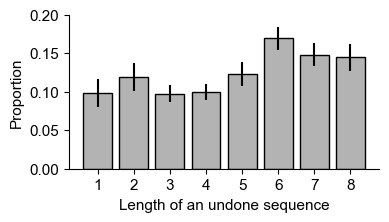

In [55]:
%matplotlib inline
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 11
fig, ax=plt.subplots(1,1,figsize=(4,2))

# count number of not nan arrays from np.mean(length_seq_persub,axis=1)
valid_subnum = np.sum(~np.isnan(np.mean(length_undone_p,axis=1)))


ax.bar(np.arange(0,8),np.nanmean(length_undone_p,axis=0), color=[.7,.7,.7], edgecolor = 'k',
        yerr=np.nanstd(length_undone_p,axis = 0)/np.sqrt(valid_subnum))
ax.set_xticks(np.arange(0,8))
ax.set_xticklabels(['1','2','3','4','5','6','7','8'])

# set yticks
ax.set_yticks(np.arange(0,.3,.05))

# set ylim
ax.set_ylim([0,.2])

# remove top and right borders
sns.despine()

# set y label
ax.set_ylabel('Proportion')
# set x label
ax.set_xlabel('Length of an undone sequence')

# save figure
fig.savefig(out_dir+'length_undone.png', dpi=300, bbox_inches='tight')


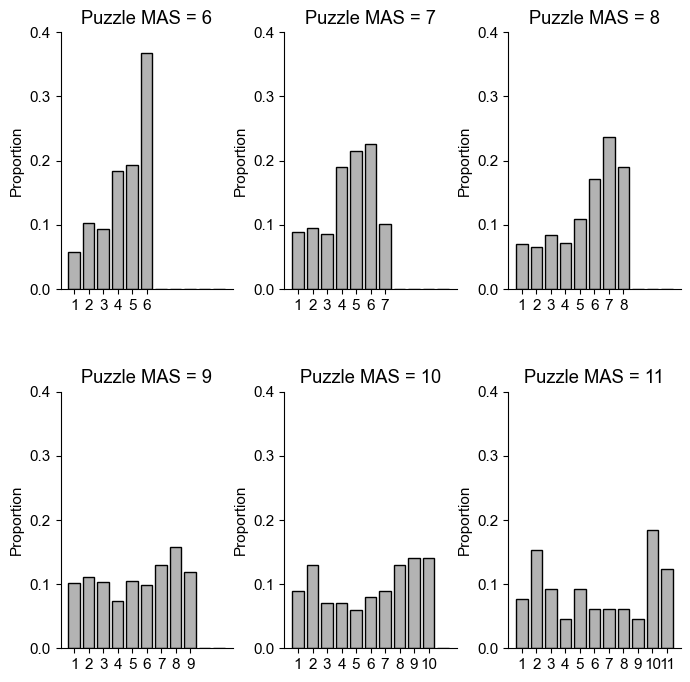

In [56]:
length_undone_p
%matplotlib inline
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 11
fig, ax = plt.subplots(2, 3, figsize=(8, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# mas_undone_tot
# length_undone_tot
# for every unique mas_undone_tot, get histogram of length_undone_tot
for mas in np.arange(7,13):
    # print(mas)
    hist, bin_ = np.histogram(np.array(length_undone_tot)[np.array(mas_undone_tot)==mas], bins=np.arange(0,12)+0.5)
    # print(hist)

    # plot hist as bar plot
    ax[np.unravel_index(mas-7,(2,3))].bar(np.arange(0,11), hist/hist.sum(), color=[.7,.7,.7], edgecolor = 'k')
    # title for each subplot
    ax[np.unravel_index(mas-7,(2,3))].set_title('Puzzle MAS = '+str(mas-1))
    # set ylim and yticks
    ax[np.unravel_index(mas-7,(2,3))].set_ylim([0,.4])
    ax[np.unravel_index(mas-7,(2,3))].set_yticks(np.arange(0,.5,.1))


    # xtickslabel
    ax[np.unravel_index(mas-7,(2,3))].set_xticks(np.arange(0,mas-1))
    ax[np.unravel_index(mas-7,(2,3))].set_xticklabels(np.arange(1,mas))

    # remove boxes
    sns.despine(ax=ax[np.unravel_index(mas-7,(2,3))])

    # ytitle
    ax[np.unravel_index(mas-7,(2,3))].set_ylabel('Proportion')


# save figure
fig.savefig(out_dir+'length_undone_by_puzzle_MAS.png', dpi=300, bbox_inches='tight')

### How often overlaps with previous paths

####  (including length = 1; which means only a city overlapped)

In [57]:
stat12, p12 = wilcoxon(overlap_seq_inorder_p[:,0],overlap_seq_inorder_p[:,1])
print(stat12)
print(p12)

nan
nan


In [58]:
stat34, p34 = wilcoxon(overlap_seq_inorder_inlen_p[:,2],overlap_seq_inorder_inlen_p[:,3])
print(stat34)
print(p34)

nan
nan


In [59]:
np.nanmean(overlap_seq_inorder_inlen_p,axis=0)

array([0.22203438, 0.44519809, 0.15847599, 0.07370274, 0.04334751,
       0.01729776, 0.03994354])

# redoing after undoing

some of the plots with fixed length of undone path

In [60]:
import copy
def get_tortuosity(pathList, pzi = 15):
    def cal_dist(xy1, xy2):
        return np.sqrt(np.sum((np.array(xy1)-np.array(xy2))**2))

    pathList_ = copy.deepcopy(pathList)

    ### for the def
    import json
    with open('./util/basicMap.json','rb') as f:
        basic_map = json.load(f)
    tortuosity = []
    ###

    map_pz = basic_map[pzi]

    import numpy as np
    for _ in range(len(pathList_)):
        path = pathList_.pop(0)
        if len(path)>1:
            ct_init = path.pop(0)
#             print(path)
#             print('init{}_tgt{}'.format(ct_init, path[-1]))
#             print('map_init{}_map_tgt{}'.format(map_pz['xy'][ct_init], map_pz['xy'][path[-1]]))
            d_straight = cal_dist(map_pz['xy'][ct_init], map_pz['xy'][path[-1]])
            d_zigzag = 0
            for _ in range(len(path)):
                ct_tgt = path.pop(0)
                d_zigzag += cal_dist(map_pz['xy'][ct_init], map_pz['xy'][ct_tgt])
                ct_init = ct_tgt
            tortuosity.append([d_zigzag, d_straight])
        else:
            tortuosity.append([np.nan, np.nan])
    return np.array(tortuosity)


In [61]:
data_ = []
data_firstundo_ = []
data_overlap_inorder = []
data_overlap_inorder_p = []
data_overlap_rglssorder = []
data_overlap_rglssorder_p = []
data_mas_123 = []

for sub in range(100):
    dat_sbj = sc_data_choice_level[sc_data_choice_level['subjects'] == sub].sort_values(["puzzleID", "index"])
    data_puzzle = []
    data_puzzle_firstundo = []
    data_overlap_inorder_puzzle = []
    data_overlap_inorder_p_puzzle = []
    data_overlap_rglssorder_puzzle = []
    data_overlap_rglssorder_p_puzzle = []
    data_mas_123_puzzle = []

    print(sub)

    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()

        firstUndo_idx = dat_sbj_pzi[dat_sbj_pzi["firstUndo"] == 1].index
        path_bf_undo = dat_sbj_pzi["currMas"][firstUndo_idx - 1]  # the mas of the state before undo

        lastUndo_idx = dat_sbj_pzi[dat_sbj_pzi["lastUndo"] == 1].index
        path_af_undo = dat_sbj_pzi["currMas"][lastUndo_idx + 1]  # the mas of the state after undo

        submit_idx = pd.Int64Index([len(dat_sbj_pzi) - 1])

        if len(firstUndo_idx) > 0:
            if len(firstUndo_idx) == 1:  #
                t_idx = (firstUndo_idx[1:] - 1).to_list()
                t_idx.append(submit_idx.item())
                seq_bf = dat_sbj_pzi["path"][firstUndo_idx - 1]
                seq_af = dat_sbj_pzi["path"][t_idx]
                seq_im = dat_sbj_pzi["path"][lastUndo_idx]
                currmas_bf = dat_sbj_pzi["currMas"][lastUndo_idx - 1]
                currmas_af = dat_sbj_pzi["currMas"][lastUndo_idx + 1]


            else:
                seq_bf = dat_sbj_pzi["path"][firstUndo_idx - 1]
                t_idx = (firstUndo_idx[1:] - 1).to_list()
                t_idx.append(submit_idx.item())
                seq_af = dat_sbj_pzi["path"][t_idx]
                seq_im = dat_sbj_pzi["path"][lastUndo_idx]
                currmas_bf = dat_sbj_pzi["currMas"][lastUndo_idx - 1]
                currmas_af = dat_sbj_pzi["currMas"][lastUndo_idx + 1]

            firstundoidx = firstUndo_idx.to_numpy()-1
            lastundoidx = lastUndo_idx.to_numpy()
            tidx = np.array(t_idx) + 1
            tidx[-1] -= 1

            length_firstundo_mas_tortuosity = []
            length_mas_123 = []
            length_mas_tortuosity = []
            length_inorder_p = []
            length_inorder = []
            length_rglssorder_p = []
            length_rglssorder = []
            for i in range(len(firstundoidx)):
                currnct = dat_sbj_pzi["currNumCities"][firstundoidx[i]:tidx[i]].to_numpy()
                currmas = dat_sbj_pzi["currMas"][firstundoidx[i]:tidx[i]].to_numpy()
                currnct = currnct - min(currnct)
                currpath = dat_sbj_pzi["path"][firstundoidx[i]:tidx[i]].to_list()
                currpath = [currpath[i].strip('[').strip(']') for i in range(len(currpath))]
                currpath = [[int(i) for i in currpath[j].split(', ')] for j in range(len(currpath))]


                seq_im = dat_sbj_pzi["path"][lastundoidx[i]]
                pathStr_im = seq_im.strip('[').strip(']')
                pathList_im = [int(i) for i in pathStr_im.split(', ')]

                currpath = [np.setdiff1d(currpath[i], pathList_im).tolist() for i in range(len(currpath))]
                pathafter = [np.setdiff1d(pathList_af[i], pathList_im).tolist() for i in range(len(pathList_af))]

                # return nan if length of list is smaller than 1 or eqaul to 1, otherwise return get_tortuosity
                tortuosity = [np.nan if len(currpath[i])<2 else get_tortuosity([currpath[i]], pzi) for i in range(len(currpath))]
                # update tortuosity if the element is not nan, devide first number with the second number
                tortuosity = [tortuosity[i][0][0]/tortuosity[i][0][1] if np.all(np.isnan(tortuosity[i]))==False else np.nan for i in range(len(tortuosity))]

                for j in range(1,9):
                    # return index of currnct is equal to i
                    idx = np.where(currnct==j)[0]

                    if len(idx)<2:
                        length_mas_tortuosity.append([j, np.nan, np.nan])
                        length_mas_123.append([j, np.nan, np.nan, np.nan])
                        length_firstundo_mas_tortuosity.append([j,dat_sbj_pzi["currMas"][0], np.nan, np.nan])
                        length_rglssorder.append([j, np.nan])
                        length_rglssorder_p.append([j, np.nan])
                        length_inorder.append([j, np.nan])
                        length_inorder_p.append([j, np.nan])
                    else:
                        length_mas_tortuosity.append([j, currmas[idx[1]]-currmas[idx[0]], tortuosity[idx[1]]-tortuosity[idx[0]]])
                        length_firstundo_mas_tortuosity.append([j,dat_sbj_pzi["currMas"][0], currmas[idx[1]]-currmas[idx[0]], tortuosity[idx[1]]-tortuosity[idx[0]]])
                        idx_2 = np.where(currnct==0)[0]
                        # if len(idx_2)==2 then select the first one
                        if len(idx_2)==2:
                            idx_2 = idx_2[0]
                        else:
                            idx_2 = idx_2.item()
                        currmas2 = currmas[idx_2].item()

                        length_mas_123.append([j,currmas2 - currmas[idx[0]], currmas[idx[1]]-currmas2, currmas[idx[1]]-currmas[idx[0]]]) # 2-1 3-2 3-1

                        temp = get_overlaplist(currpath[idx[0]],currpath[idx[1]])
                        temp = trimmer(temp)
                        if len(temp)==0:
                            temp.append([])
                        overlap_num_city_ = 0
                        for seq in temp:
                            overlap_num_city_ += len(seq)
                        len_seq_inorder_2 =[]
                        tempcurd = []
                        for s in temp:
                            if len(s)==0:
                                len_seq_inorder_2.append(0)
                            else:
                                len_seq_inorder_2.append(len(s))
                        for element in len_seq_inorder_2:
                            length_inorder_p.append([j,element/len(currpath[idx[1]])])
                            length_inorder.append([j,element])
                        length_rglssorder_p.append([j,overlap_num_city_/len(currpath[idx[1]])])
                        length_rglssorder.append([j,overlap_num_city_])
            data_puzzle.append(length_mas_tortuosity)
            data_puzzle_firstundo.append(length_firstundo_mas_tortuosity)
            data_overlap_inorder_p_puzzle.append(length_inorder_p)
            data_overlap_inorder_puzzle.append(length_inorder)
            data_overlap_rglssorder_p_puzzle.append(length_rglssorder_p)
            data_overlap_rglssorder_puzzle.append(length_rglssorder)
            data_mas_123_puzzle.append(length_mas_123)

    data_.append(data_puzzle)
    data_firstundo_.append(data_puzzle_firstundo)
    data_overlap_inorder_p.append(data_overlap_inorder_p_puzzle)
    data_overlap_inorder.append(data_overlap_inorder_puzzle)
    data_overlap_rglssorder_p.append(data_overlap_rglssorder_p_puzzle)
    data_overlap_rglssorder.append(data_overlap_rglssorder_puzzle)
    data_mas_123.append(data_mas_123_puzzle)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [62]:
mas = []
tortuosity = []

mas_atend = []
tortuosity_atend = []

overlap_inlen_p = []
overlap_rglss_p = []

overlap_inlen = []
overlap_rglss = []
for sub in range(100):
    mas_length_puzzle = []
    tortuosity_puzzle = []

    mas_length_atend_puzzle = []
    tortuosity_atend_puzzle = []


    overlap_inorder_p_puzzle = []
    overlap_inorder_puzzle = []
    overlap_rglssorder_p_puzzle = []
    overlap_rglssorder_puzzle = []
    for minlen in range(1,9):
        mas_length_atend_minlen = []
        tortuosity_atend_minlen = []

        mas_length_minlen = []
        tortuosity_minlen = []

        overlap_inorder_p_minlen  = []
        overlap_inorder_minlen    = []
        overlap_rglssorder_p_minlen  = []
        overlap_rglssorder_minlen    = []



        for pzi in range(len(data_[sub])):
            data_puzzle = np.array(data_[sub][pzi]).copy()

            # find data_puzzle with column[0] is equal to minlen
            idx_ = np.where(data_puzzle[:,0]==minlen)[0]

            mas_length_minlen.extend(data_puzzle[idx_,1])
            tortuosity_minlen.extend(data_puzzle[idx_,2])


            data_overlap_inorder_puzzle = np.array(data_overlap_inorder[sub][pzi]).copy()

            # find data_puzzle with column[0] is equal to 5, 6 ,7
            idx_ = np.where(data_overlap_inorder_puzzle[:,0]==minlen)[0]
            overlap_inorder_minlen.extend(np.array(data_overlap_inorder_puzzle[idx_,1:]))

            data_overlap_rglssorder_puzzle = np.array(data_overlap_rglssorder[sub][pzi]).copy()

            # find data_puzzle with column[0] is equal to 5, 6 ,7
            idx_ = np.where(data_overlap_rglssorder_puzzle[:,0]==minlen)[0]
            overlap_rglssorder_minlen.extend(np.array(data_overlap_rglssorder_puzzle[idx_,1:]))

            data_overlap_inorder_p_puzzle = np.array(data_overlap_inorder_p[sub][pzi]).copy()

            # find data_puzzle with column[0] is equal to 5, 6 ,7
            idx_ = np.where(data_overlap_inorder_p_puzzle[:,0]==minlen)[0]
            overlap_inorder_p_minlen.extend(np.array(data_overlap_inorder_p_puzzle[idx_,1:]))

            data_overlap_rglssorder_p_puzzle = np.array(data_overlap_rglssorder_p[sub][pzi]).copy()

            # find data_puzzle with column[0] is equal to 5, 6 ,7
            idx_ = np.where(data_overlap_rglssorder_p_puzzle[:,0]==minlen)[0]
            overlap_rglssorder_p_minlen.extend(np.array(data_overlap_rglssorder_p_puzzle[idx_,1:]))

            data_puzzle = np.array(data_[sub][pzi]).copy()
            # data puzzle that has no nan
            data_puzzle = data_puzzle[~np.isnan(data_puzzle[:,1]),:]

            idxes = np.where(data_puzzle[np.arange(1,data_puzzle.shape[0]),0] < data_puzzle[np.arange(0,data_puzzle.shape[0]-1),0])[0]
            #concatenate idxes with the last index of data_puzzle
            idxes = np.concatenate((idxes,np.array([data_puzzle.shape[0]-1])))

            # print(idxes)
            # print(data_puzzle)
            # print('*'*10)
            #idxes that is not nan in data_puzzle
            # idxes = np.where(~np.isnan(data_puzzle[:,1]))[0]

            # print(idxes)

            idx_ = np.where(data_puzzle[:,0]==minlen)[0]
            # intersect idxes and idx_
            idxes = np.intersect1d(idxes,idx_)

            mas_length_atend_minlen.extend(data_puzzle[idxes,1])
            tortuosity_atend_minlen.extend(data_puzzle[idxes,2])

        if len(overlap_inorder_minlen)==0:
            overlap_inorder_puzzle.append([np.nan])
        else:
            overlap_inorder_puzzle.append(np.nanmean(overlap_inorder_minlen,axis=0))

        if len(overlap_rglssorder_minlen)==0:
            overlap_rglssorder_puzzle.append([np.nan])
        else:
            overlap_rglssorder_puzzle.append(np.nanmean(overlap_rglssorder_minlen,axis=0))

        if len(overlap_inorder_p_minlen)==0:
            overlap_inorder_p_puzzle.append([np.nan])
        else:
            overlap_inorder_p_puzzle.append(np.nanmean(overlap_inorder_p_minlen,axis=0))

        if len(overlap_rglssorder_p_minlen)==0:
            overlap_rglssorder_p_puzzle.append([np.nan])
        else:
            overlap_rglssorder_p_puzzle.append(np.nanmean(overlap_rglssorder_p_minlen,axis=0))


        mas_length_puzzle.append(np.nanmean(mas_length_minlen))
        if minlen>2:
            tortuosity_puzzle.append(np.nanmean(tortuosity_minlen))
        else:
            tortuosity_puzzle.append(np.nan)

        mas_length_atend_puzzle.append(np.nanmean(mas_length_atend_minlen))
        if minlen>2:
            tortuosity_atend_puzzle.append(np.nanmean(tortuosity_atend_minlen))
        else:
            tortuosity_atend_puzzle.append(np.nan)

    mas.append(mas_length_puzzle)
    tortuosity.append(tortuosity_puzzle)


    mas_atend.append(mas_length_atend_puzzle)
    tortuosity_atend.append(tortuosity_atend_puzzle)

    overlap_inlen.append(np.array(overlap_inorder_puzzle))
    overlap_rglss.append(np.array(overlap_rglssorder_puzzle))
    overlap_inlen_p.append(np.array(overlap_inorder_p_puzzle))
    overlap_rglss_p.append(np.array(overlap_rglssorder_p_puzzle))

mas = np.array(mas)
tortuosity = np.array(tortuosity)

mas_atend = np.array(mas_atend)
tortuosity_atend = np.array(tortuosity_atend)

overlap_inlen = np.array(overlap_inlen).squeeze()
overlap_rglss = np.array(overlap_rglss).squeeze()

overlap_inlen_p = np.array(overlap_inlen_p).squeeze()
overlap_rglss_p = np.array(overlap_rglss_p).squeeze()

/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_97199/3535788570.py:122: RuntimeWarning: Mean of empty slice
  mas_length_atend_puzzle.append(np.nanmean(mas_length_atend_minlen))
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_97199/3535788570.py:124: RuntimeWarning: Mean of empty slice
  tortuosity_atend_puzzle.append(np.nanmean(tortuosity_atend_minlen))
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_97199/3535788570.py:98: RuntimeWarning: Mean of empty slice
  overlap_inorder_puzzle.append(np.nanmean(overlap_inorder_minlen,axis=0))
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_97199/3535788570.py:103: RuntimeWarning: Mean of empty slice
  overlap_rglssorder_puzzle.append(np.nanmean(overlap_rglssorder_minlen,axis=0))
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_97199/3535788570.py:108: RuntimeWarning: Mean of empty slice
  overlap_inorder_p_puzzle.append(np.nanmean(overlap_inorder_p_minlen,axis=0))
/var/folders/8q/yjgzft4104

In [63]:
mas_1st_2nd_3rd = []
for sub in range(100):
    mas_1st_2nd_3rd_puzzle = []
    for minlen in range(1,9):
        mas_1st_2nd_3rd_minlne = []
        for pzi in range(len(data_[sub])):
            data_puzzle_mas_123 = np.array(data_mas_123[sub][pzi]).copy()

            idx_ = np.where(data_puzzle_mas_123[:,0]==minlen)[0]

            if len(idx_)==0:
                # append nan
                mas_1st_2nd_3rd_minlne.extend(np.array([[np.nan]*3]))
            else:
                mas_1st_2nd_3rd_minlne.extend(data_puzzle_mas_123[idx_,1:])
        if len(mas_1st_2nd_3rd_minlne)==0:
            mas_1st_2nd_3rd_puzzle.append([np.nan]*3)
        else:
            mas_1st_2nd_3rd_puzzle.append(np.nanmean(mas_1st_2nd_3rd_minlne,axis=0))

        # print(mas_1st_2nd_3rd_puzzle[-1])

    mas_1st_2nd_3rd.append(mas_1st_2nd_3rd_puzzle)

mas_1st_2nd_3rd = np.array(mas_1st_2nd_3rd)

/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_97199/942752853.py:19: RuntimeWarning: Mean of empty slice
  mas_1st_2nd_3rd_puzzle.append(np.nanmean(mas_1st_2nd_3rd_minlne,axis=0))


## overlap in order and regardless of order

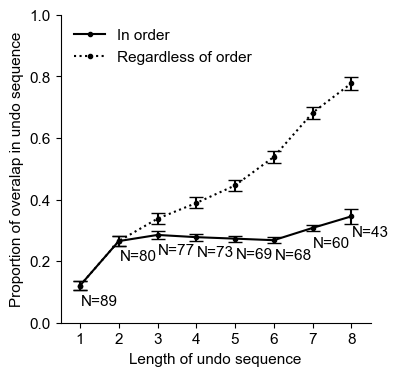

In [70]:
%matplotlib inline
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 11
fig, ax=plt.subplots(1,1,figsize=(5,5))

valid_subnum = np.sum(~np.isnan(overlap_inlen_p),axis=0)
# overlap_seq_inorder_num_norm

ax.plot(np.arange(0,8), np.nanmean(overlap_inlen_p,axis=0), color='k', marker='.')
ax.errorbar(np.arange(0,8), np.nanmean(overlap_inlen_p,axis=0), yerr=np.nanstd(overlap_inlen_p,axis=0)/np.sqrt(valid_subnum),
            linestyle='', color='k', capsize=5)


ax.plot(np.arange(0,8), np.nanmean(overlap_rglss_p,axis=0), color='k', linestyle=':',marker='.')
ax.errorbar(np.arange(0,8), np.nanmean(overlap_rglss_p,axis=0), yerr=np.nanstd(overlap_rglss_p,axis=0)/np.sqrt(valid_subnum),
            linestyle='', color='k', capsize=5)


for i in range(8):
    ax.text(i + 0.5, np.nanmean(overlap_inlen_p[:,i]) -0.05, 'N='+str(valid_subnum[i]), ha='center', va='center', color='k')

# remove top and right borders
sns.despine()
# set x ticks
ax.set_xticks(np.arange(0,8))
ax.set_xticklabels(np.arange(1,9))
ax.set_xlim([-0.5,7.5])
ax.set_ylim([0,1])

# legend
ax.legend(['In order','Regardless of order'], loc='upper left', frameon=False)

# set y label
ax.set_ylabel('Proportion of overalap in undo sequence')


# set x label
ax.set_xlabel('Length of undo sequence')

#save figure
fig.savefig(out_dir + 'overlap_inorder_rglss_proportion.png', transparent=True)

## MAS gain as a function of length

In [65]:
#import ttest 1samp
from scipy.stats import ttest_1samp, ttest_rel
ps = []
for ind in range(8):
    stat,p = ttest_rel(tortuosity[(~np.isnan(tortuosity[:,ind])),ind], [0]*np.sum((~np.isnan(tortuosity[:,ind])),))
    ps.append(p)
print(ps)

[nan, nan, 0.6106349965298539, 0.12507334628349948, 0.28139715943931, 0.04516897320073992, 0.6617007820952879, 0.32152809676380184]


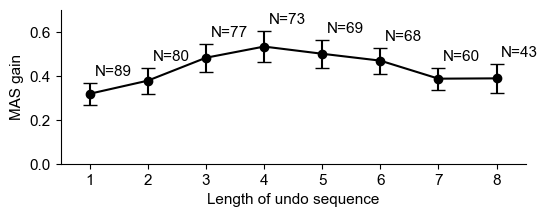

In [66]:
%matplotlib inline

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 11
fig, ax=plt.subplots(1,1,figsize=(6,2))

valid_subnum = [np.sum(~np.isnan(mas[:,i])) for i in range(8)]

# ax.plot for currmas_num_inlen_p
ax.plot(np.arange(8), np.nanmean(mas,axis=0), color='k', marker='o')
ax.errorbar(np.arange(8), np.nanmean(mas,axis=0), yerr=np.nanstd(mas,axis=0)/np.sqrt(valid_subnum),
            linestyle='', color='k', capsize=5)

# write valid_subnum as N=xx on the right top of each point
for i in range(8):
    ax.text(i + 0.4, np.nanmean(mas[:,i]) + np.nanstd(mas[:,i])/np.sqrt(valid_subnum[i])+0.05, 'N='+str(valid_subnum[i]), ha='center', va='center', color='k')

# bb = plt.bar(range(7), np.nanmean(currmas_inlen_p,axis=0),
#         color=[.7,.7,.7], edgecolor = 'k',
#         yerr=np.nanstd(currmas_inlen_p,axis = 0)/np.sqrt(currmas_inlen_p.shape[0]))

ax.set_xticks(np.arange(0,8))
ax.set_xlim([-0.5,8.5])
# set xtickslabel
ax.set_xticklabels(['1','2','3','4', '5', '6', '7', '8'])

# set y label
ax.set_ylabel('MAS gain')
# set x label
ax.set_xlabel('Length of undo sequence')
# set ylim
ax.set_yticks(np.arange(0,.7,.2))
ax.set_ylim([0,.7])

# set xlim
ax.set_xlim([-0.5,7.5])




# remove top and right borders
sns.despine()



# #statistics
# x1, x2 = 2,3
# y, h, col = np.max([bb[2].get_height(),bb[3].get_height()]) + 0.1, 0.05, 'k'
# plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
# plt.text((x1+x2)*.5, y+h, r"$p = {:f}$".format(p12), ha='center', va='bottom', color=col, fontsize = 8)

# save figure
fig.savefig(out_dir + 'mas_gain_length_of_undone_path.png', dpi=600, bbox_inches='tight')

In [67]:
mas_1st_2nd_3rd.shape

(100, 8, 3)

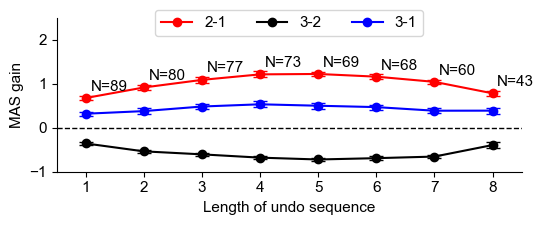

In [69]:
%matplotlib inline

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 11
fig, ax=plt.subplots(1,1,figsize=(6,2))

colors = ['r',  '0.7', 'k',]

for ii in range(3):

    valid_subnum = [np.sum(~np.isnan(mas_1st_2nd_3rd[:,i,ii])) for i in range(8)]

    # ax.plot for currmas_num_inlen_p
    ax.plot(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=0), color=colors[ii], marker='o')
    ax.errorbar(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=0), yerr=np.nanstd(mas_1st_2nd_3rd[:,:,ii],axis=0)/np.sqrt(valid_subnum),
                linestyle='', color=colors[ii], capsize=5)

    if ii == 0:
        # write valid_subnum as N=xx on the right top of each point
        for i in range(8):
            ax.text(i + 0.4, np.nanmean(mas_1st_2nd_3rd[:,i,ii]) + np.nanstd(mas_1st_2nd_3rd[:,i,ii])/np.sqrt(valid_subnum[i])+0.2, 'N='+str(valid_subnum[i]), ha='center', va='center', color='k')

    # bb = plt.bar(range(7), np.nanmean(currmas_inlen_p,axis=0),
    #         color=[.7,.7,.7], edgecolor = 'k',
    #         yerr=np.nanstd(currmas_inlen_p,axis = 0)/np.sqrt(currmas_inlen_p.shape[0]))

    ax.set_xticks(np.arange(0,8))
    ax.set_xlim([-0.5,8.5])
    # set xtickslabel
    ax.set_xticklabels(['1','2','3','4', '5', '6', '7', '8'])

    # set y label
    ax.set_ylabel('MAS gain')
    # set x label
    ax.set_xlabel('Length of undo sequence')


ax.set_ylim([-1, 2.5])
ax.set_yticks(np.arange(-1,3,1))

# set xlim
ax.set_xlim([-0.5,7.5])




# remove top and right borders
sns.despine()
#2-1 3-2 3-1
# legend in a horizontally
ax.legend(['2-1', '3-2', '3-1'], loc='upper center', bbox_to_anchor=(0.5, 1.1),
          ncol=3, fancybox=True)

# #statistics
# x1, x2 = 2,3
# y, h, col = np.max([bb[2].get_height(),bb[3].get_height()]) + 0.1, 0.05, 'k'
# plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
# plt.text((x1+x2)*.5, y+h, r"$p = {:f}$".format(p12), ha='center', va='bottom', color=col, fontsize = 8)

# save figure
fig.savefig(out_dir + 'mas_gain_length_of_undone_path_for_diff_undo.png', dpi=600, bbox_inches='tight')